# Open exploration: Policy and Uncertainty Space

## Model and dependency import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from problem_formulation import get_model_for_problem_formulation

## Dike model simulation

### Examine the policy and uncertainty space

Policy space: 265 different policies on the reference scenario

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Choose problem formulation (6)
problem_formulation_id = 6
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

In [6]:
reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "ID flood wave shape": 4,
    "planning steps": 2,
}
reference_values.update({f"discount rate {n}": 3.5 for n in planning_steps})

scen1 = {}
for key in dike_model.uncertainties:
    name_split = key.name.split("_")
    if len(name_split) == 1:
        scen1[key.name] = reference_values[key.name]
    else:
        scen1[key.name] = reference_values[name_split[1]]

ref_scenario = Scenario("reference", **scen1)

# Define zero-policy: no dike increase, no EWS, no RfR
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}
for key in dike_model.levers:
    _, suffix = key.name.split("_")
    pol0[key.name] = zero_policy[suffix]

policy0 = Policy("Policy 0", **pol0)


In [7]:
n_policies = 256

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(
        scenarios=ref_scenario,
        policies=n_policies,
        lever_sampling=Samplers.SOBOL
    )


[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 16384 policies * 1 model(s) = 16384 experiments
100%|████████████████████████████████████| 16384/16384 [11:51<00:00, 23.03it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [9]:
save_results(results, './results/policy_space_refsc_256pol.tar.gz')


[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\policy_space_refsc_256pol.tar.gz


Uncertainty space: 1024 scenarios on the reference policy

In [10]:
# Inspect uncertainty problem structure
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [11]:
n_scenarios = 1024  # Number of Sobol samples for uncertainties

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_unc = evaluator.perform_experiments(
        scenarios=n_scenarios,
        policies=policy0,
        uncertainty_sampling=Samplers.SOBOL
    )
save_results(results_unc, './results/uncertainty_space_refsc_1024sc.tar.gz')

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40960 scenarios * 1 policies * 1 model(s) = 40960 experiments
100%|████████████████████████████████████| 40960/40960 [28:11<00:00, 24.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\uncertainty_space_refsc_1024sc.tar.gz


### Analysis of the Policy Space

In [66]:
import itertools

# Load the results from the tar.gz file
results_pol = load_results('./results/policy_space_refsc_256pol.tar.gz')

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\policy_space_refsc_256pol.tar.gz


In [67]:
pol_experiments, pol_outcomes = results_pol

# Convert the damage_sobol array to a DataFrame
pol_experiments_df = pd.DataFrame(pol_experiments)
    
# Convert outcomes_sobol dictionary to df
policy_outcomes_df = pd.DataFrame.from_dict(pol_outcomes)

# Merge DataFrames based on their index
policy_space = pd.merge(pol_experiments_df, policy_outcomes_df, left_index=True, right_index=True)

# Save the merged DataFrame to a CSV file
# policy_space.to_csv('policy_space.csv', index=True)
policy_space.head()


,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,EWS_DaysToThreat,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
0,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4,reference,0,dikesnet,6.293287e+06,7.805438e+08,1.723200e+09,567.524976,0.000839,2.503744e+09
1,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4,reference,1,dikesnet,6.293287e+06,7.805438e+08,1.723200e+09,567.524976,0.000839,2.503744e+09
2,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4,reference,2,dikesnet,6.293287e+06,7.805438e+08,1.723200e+09,567.524976,0.000839,2.503744e+09
3,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4,reference,3,dikesnet,6.293287e+06,7.805438e+08,1.638600e+09,567.524976,0.000839,2.419144e+09
4,3.5,3.5,3.5,4,175.0,0.5,1.5,175.0,0.5,1.5,...,4,reference,4,dikesnet,6.293287e+06,7.805438e+08,1.723200e+09,567.524976,0.000839,2.503744e+09


In [68]:
#check all columns names
print(policy_space.columns)

Index(['discount rate 0', 'discount rate 1', 'discount rate 2',
       'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate',
       'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail',
       'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax',
       'A.5_pfail', 'A.5_Brate', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 

Visualise the Sobol effects

In [69]:
# Translate the policy space dataframe back into a dictionary in order for the sobol calculations to work
policy_space_dict = {col: policy_space[col].to_numpy() for col in policy_space.columns}
# policy_space_dict

In [70]:
pol_results = load_results('./results/policy_space_refsc_256pol.tar.gz')
pol_experiments, pol_outcomes = pol_results

model, steps = get_model_for_problem_formulation(6)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\policy_space_refsc_256pol.tar.gz


In [71]:
#Function used to flatten Sobol S2 Dictionary Output

def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        array = []
        for row in value:
            array.extend(row)
        flattened_dict[key] = array

    return flattened_dict

In [72]:
def plot_sobol_effects(run_dict, variable, order, timestep):
    # Prepare Sobol variables
    problem = get_SALib_problem(levers)
    outcome_var = variable
    Si = sobol.analyze(problem, run_dict[outcome_var], print_to_console=False)
    
    
    if order == 'first':
        # Process dataframe: Filter S1+ST
        Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
        
        if timestep == 'all':
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df[['S1','ST']]
            err = Si_df[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
                
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            
            # Filter Si_df based on filtered_names
            Si_df_filtered = Si_df.loc[filtered_names]
            
            # Visualize Sobol indices for filtered names
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df_filtered[['S1','ST']]
            err = Si_df_filtered[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
    if order =='second':
        
        if timestep == 'all':
            Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = S2_df[["S2"]].dropna()
            err = S2_df[['S2_conf']].dropna()
            
            fig.set_size_inches(100,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
            
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            combinations = list(itertools.product(filtered_names, repeat=2))
            
            # Assuming Si_filter_s2 and S2_df are generated as in your code snippet
            Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))
            
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)
            S2_df_filtered = S2_df_sorted.loc[combinations]
            
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            # Drop NaN values from 'S2' and 'S2_conf' columns
            indices = S2_df_filtered[["S2"]].dropna()
            err = S2_df_filtered[['S2_conf']].dropna()
            
            fig.set_size_inches(20,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
    
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.suptitle(f'{variable} {order} order sobol effects ({timestep})', fontsize=15, y=0.93)
    fig.subplots_adjust(bottom=0.3)
    
    plt.show()
    return

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


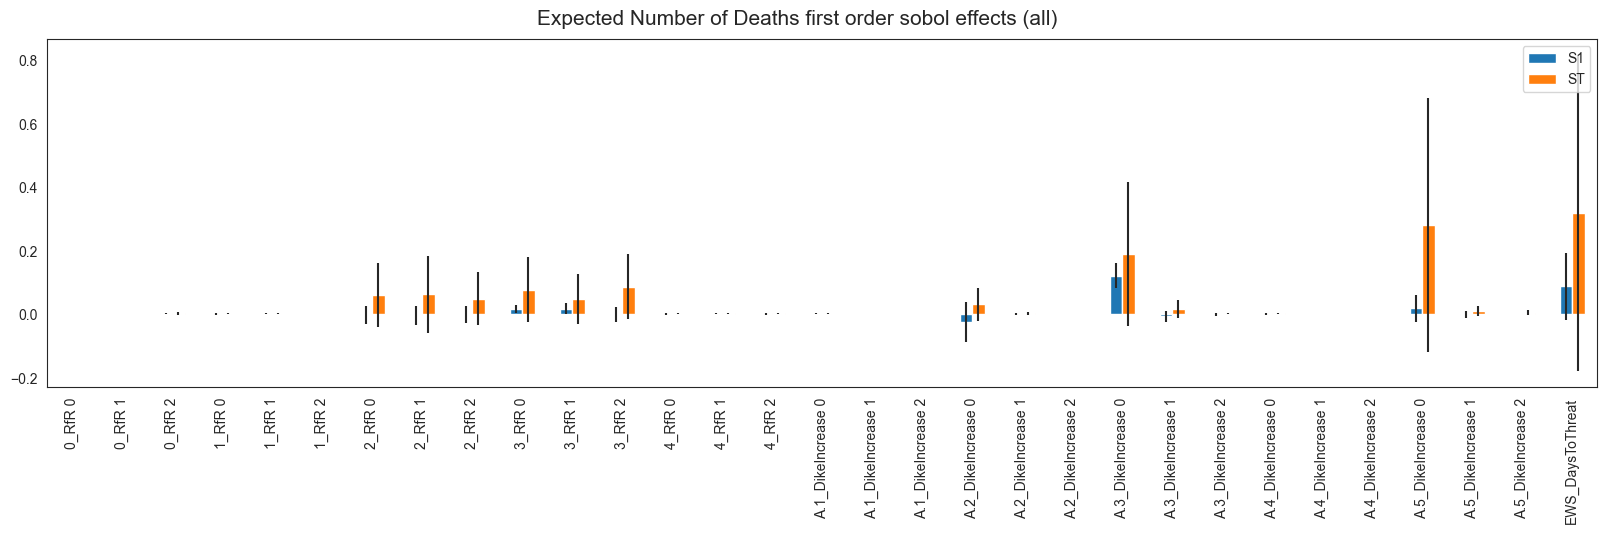

In [73]:
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'first','all')

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


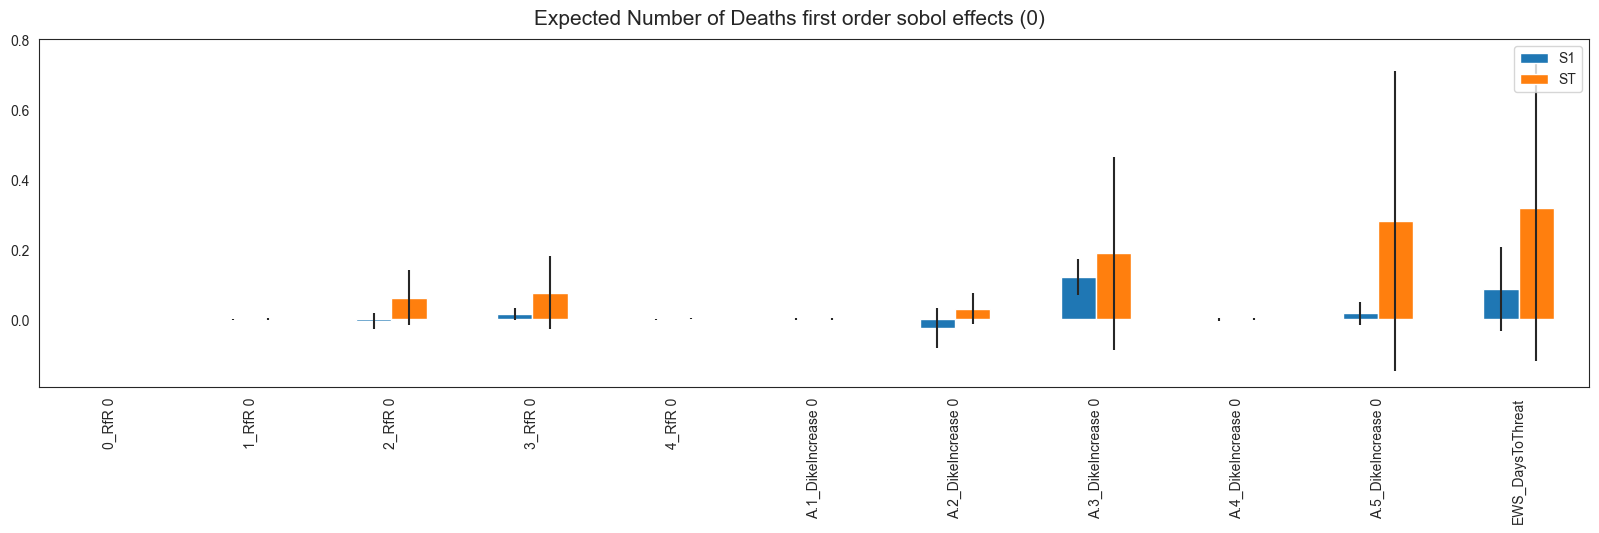

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


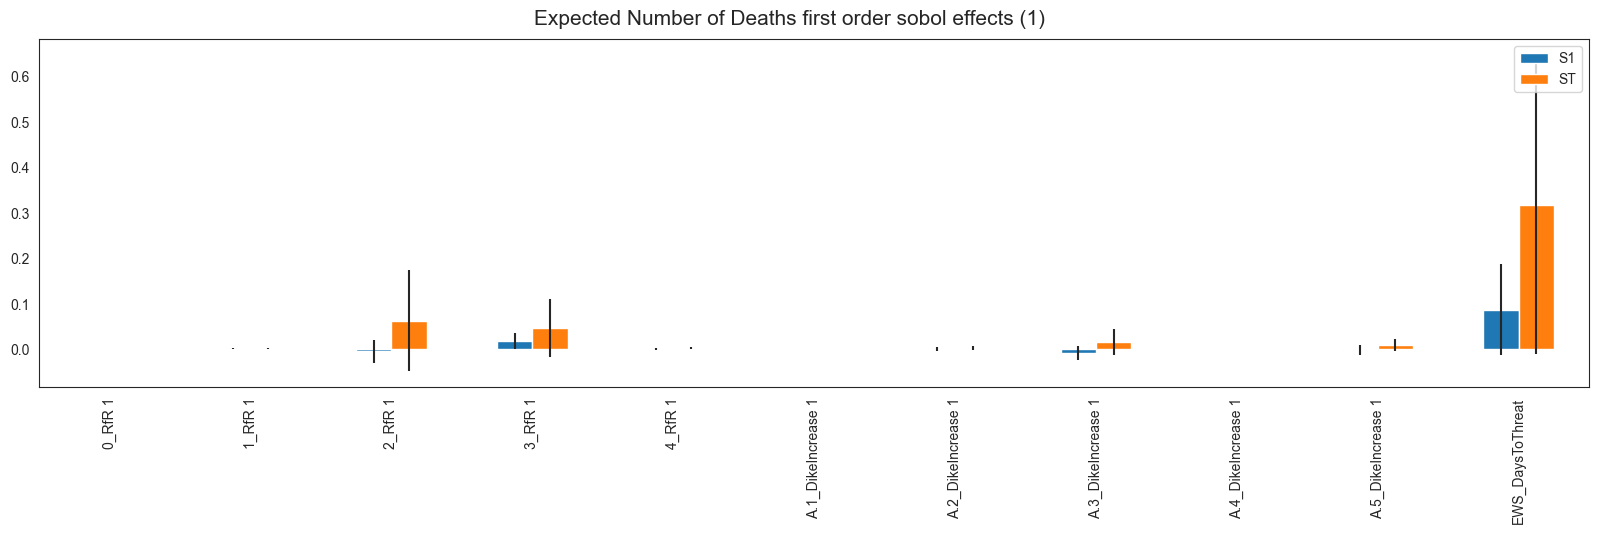

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


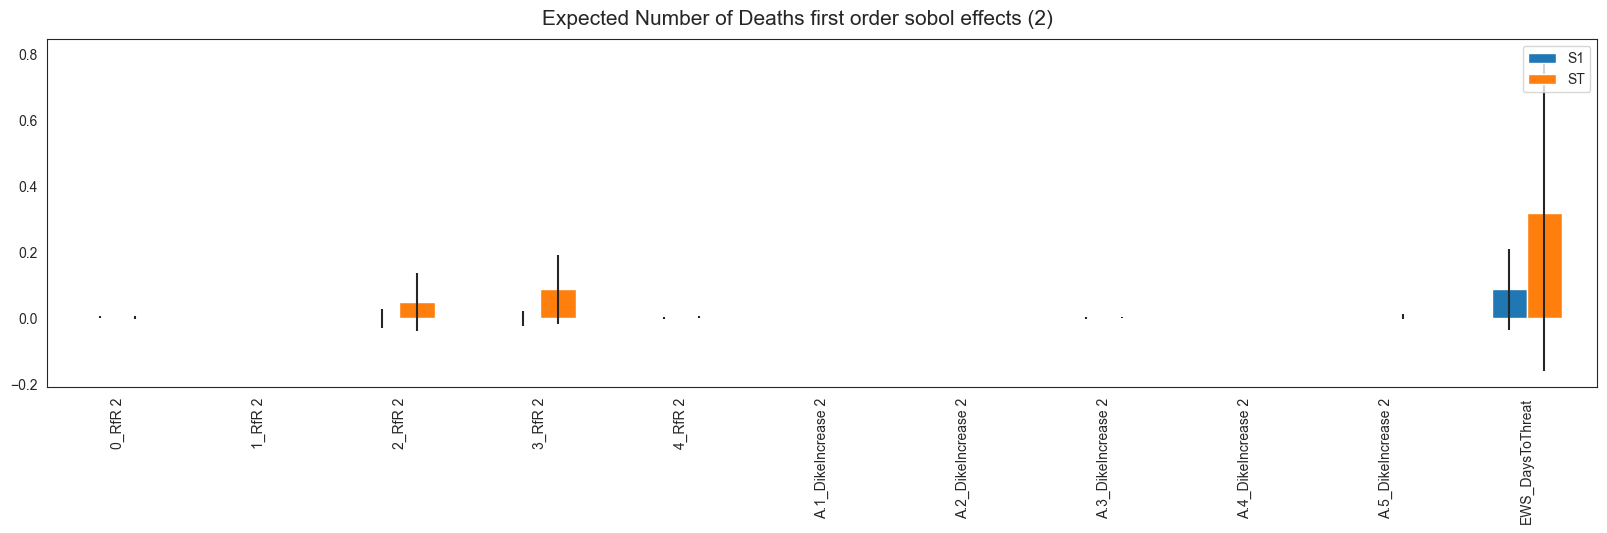

In [74]:
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'first','0')
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'first','1')
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'first','2')

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


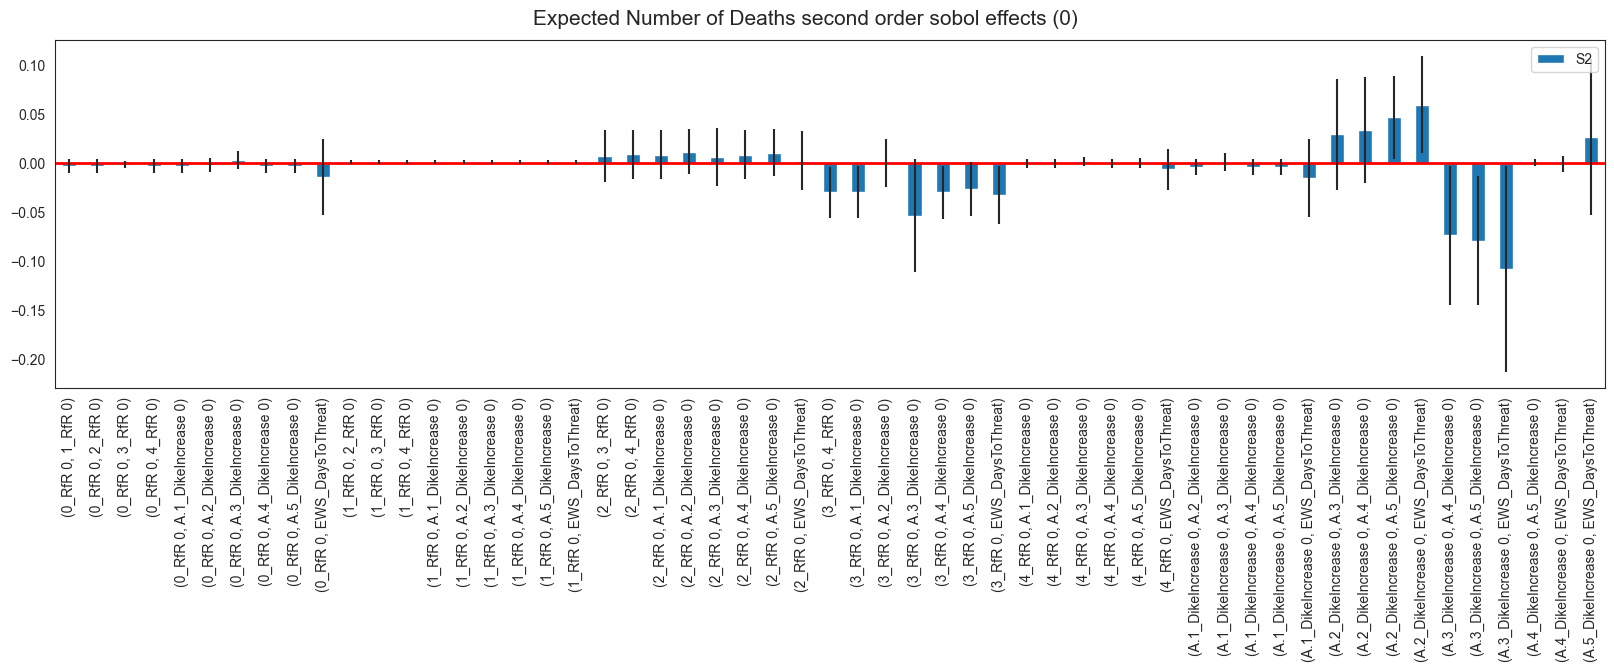

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


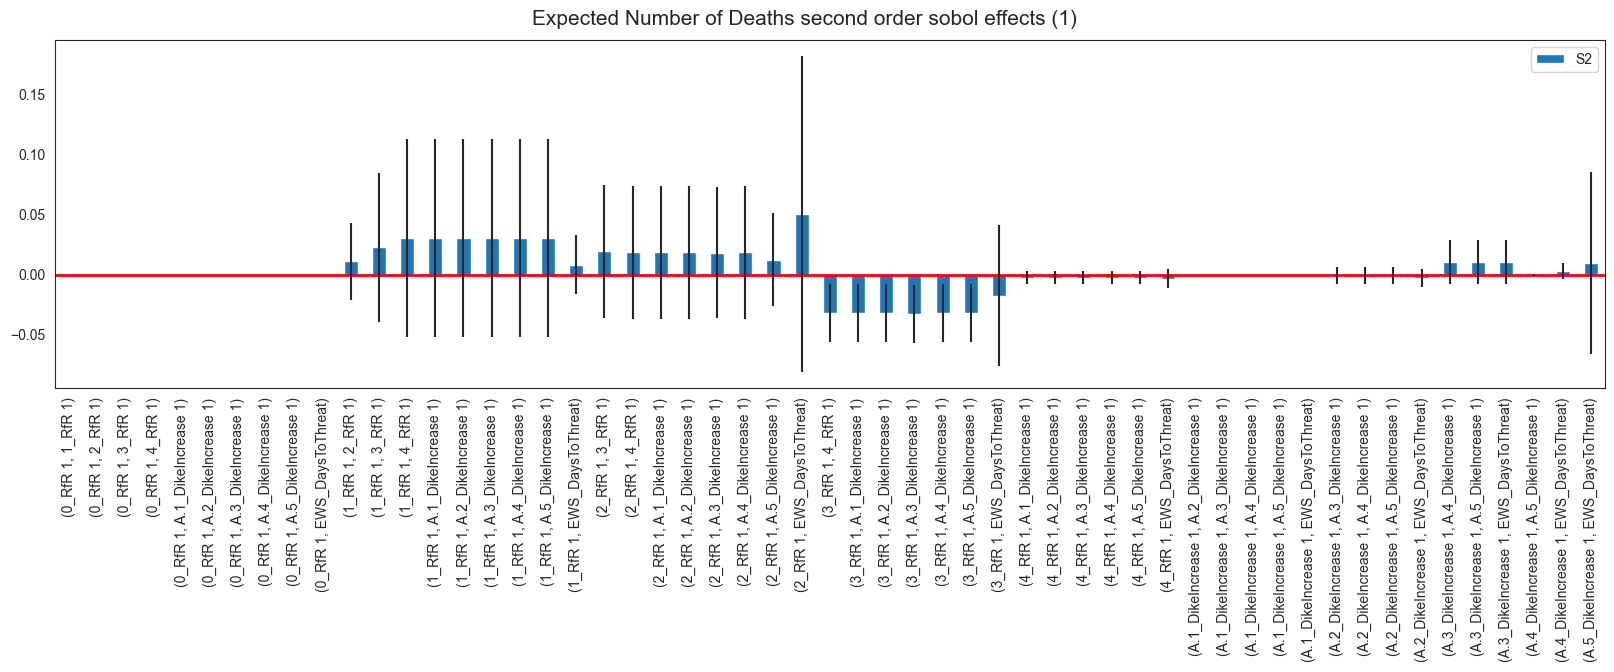

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


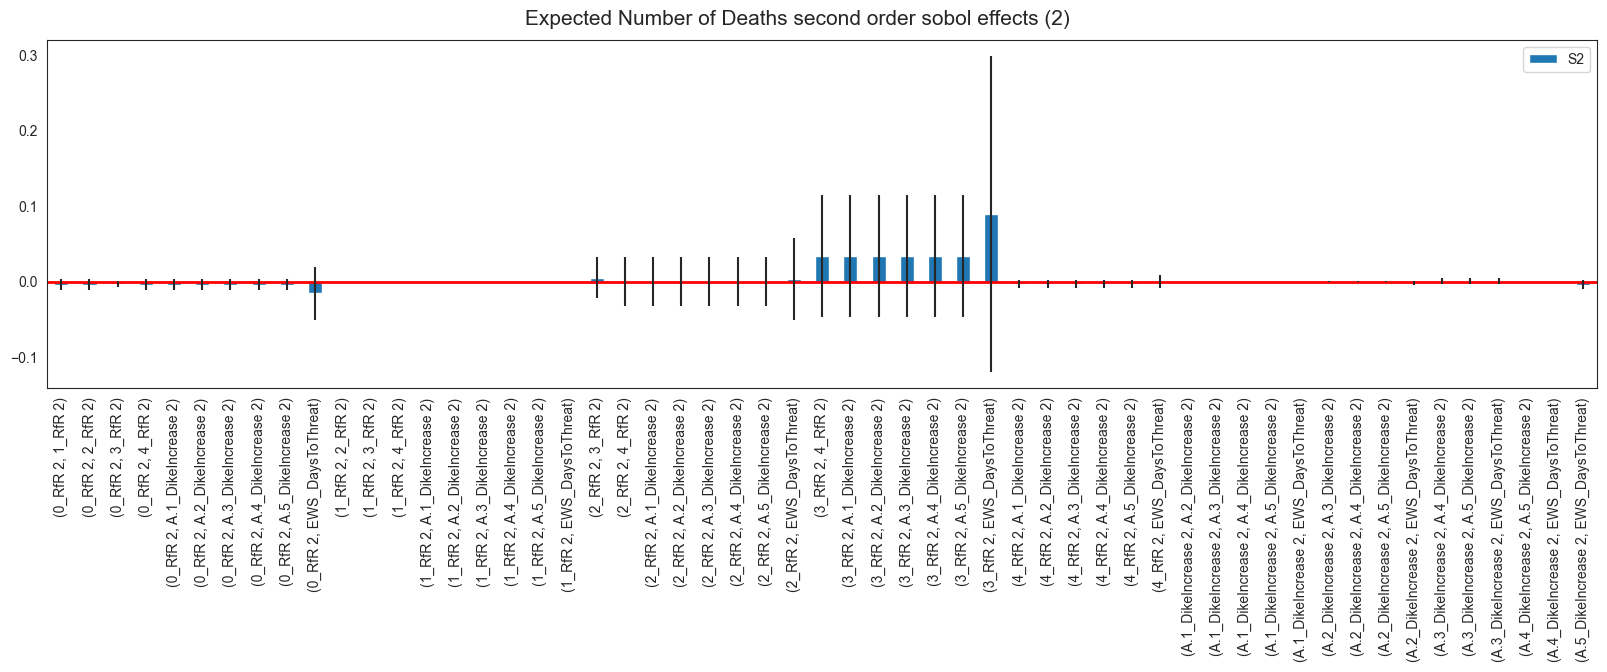

In [75]:
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'second','0')
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'second','1')
plot_sobol_effects(policy_space_dict,'Expected Number of Deaths', 'second','2')

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


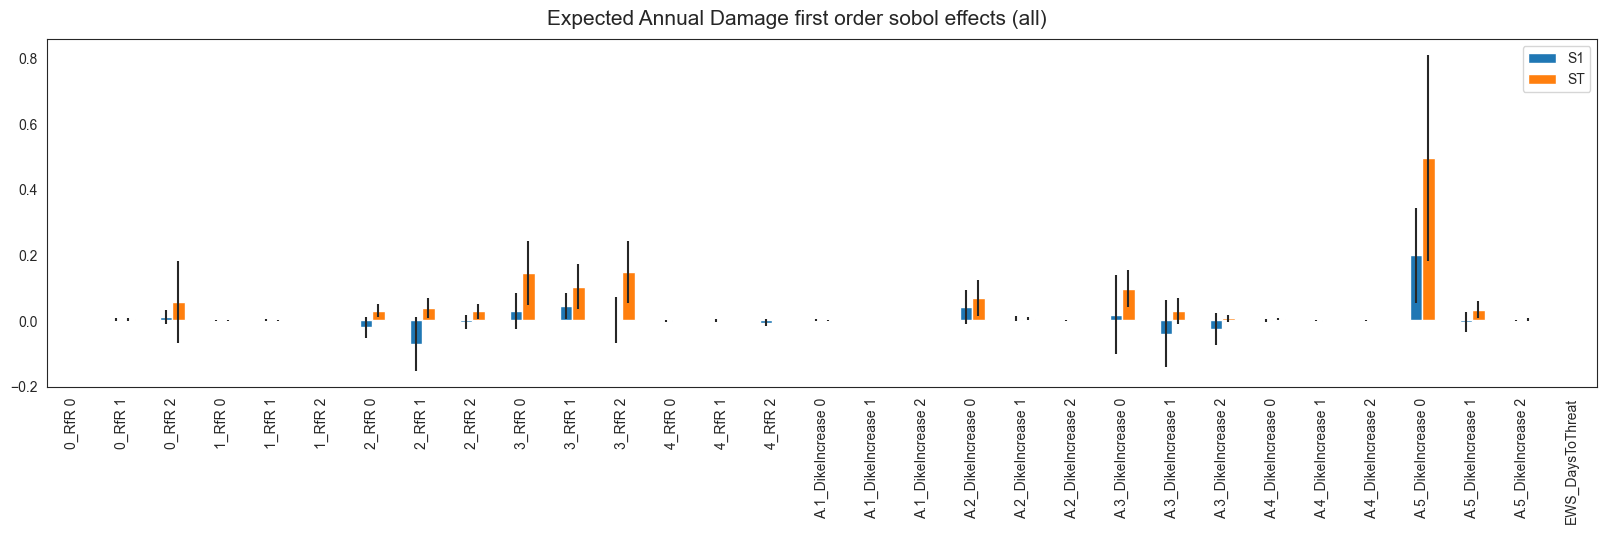

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


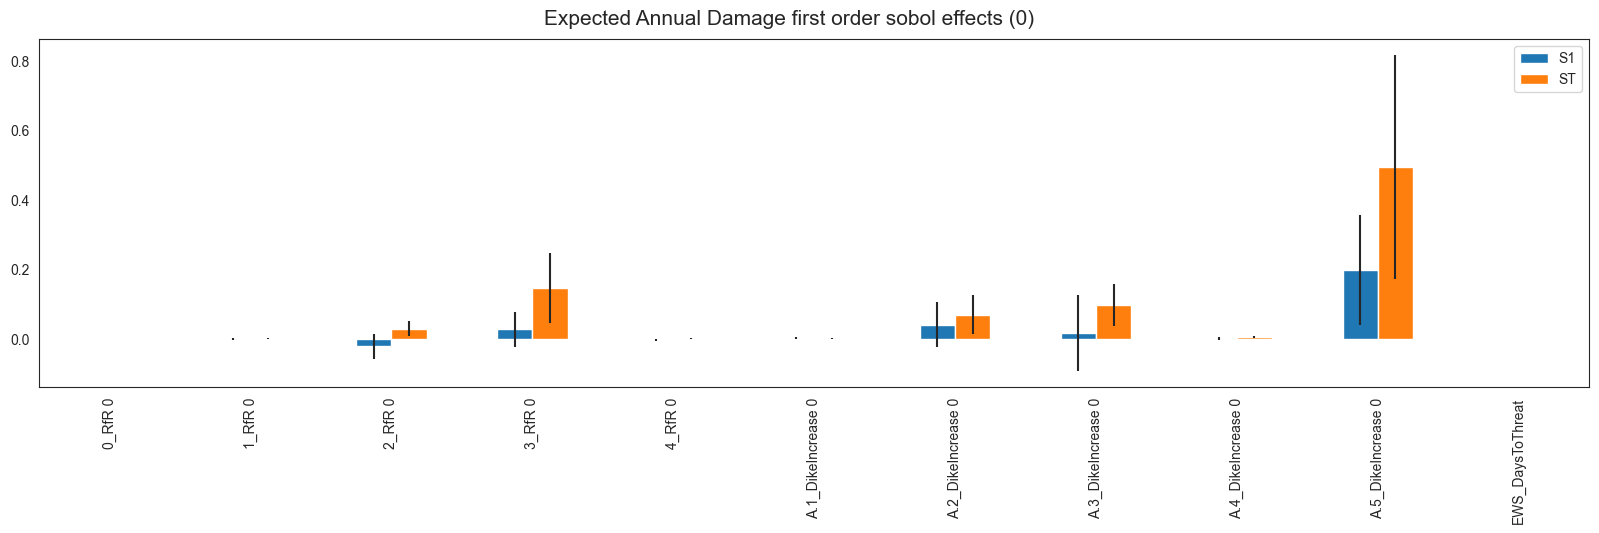

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


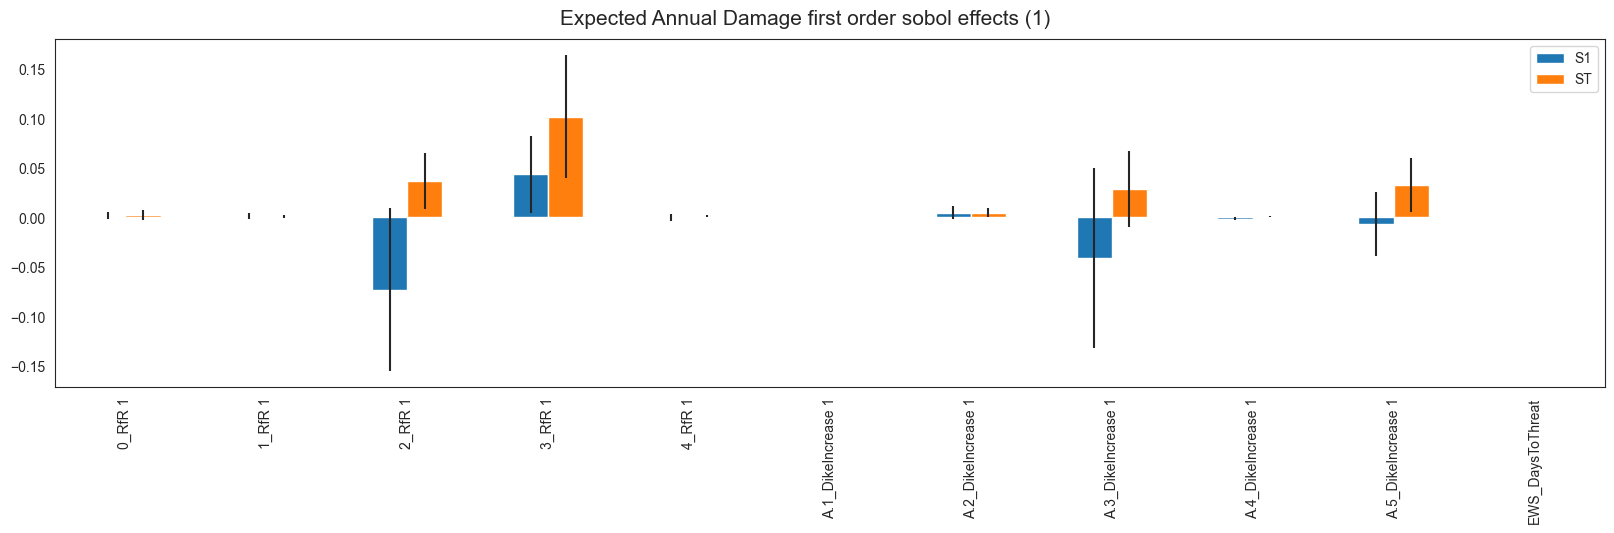

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


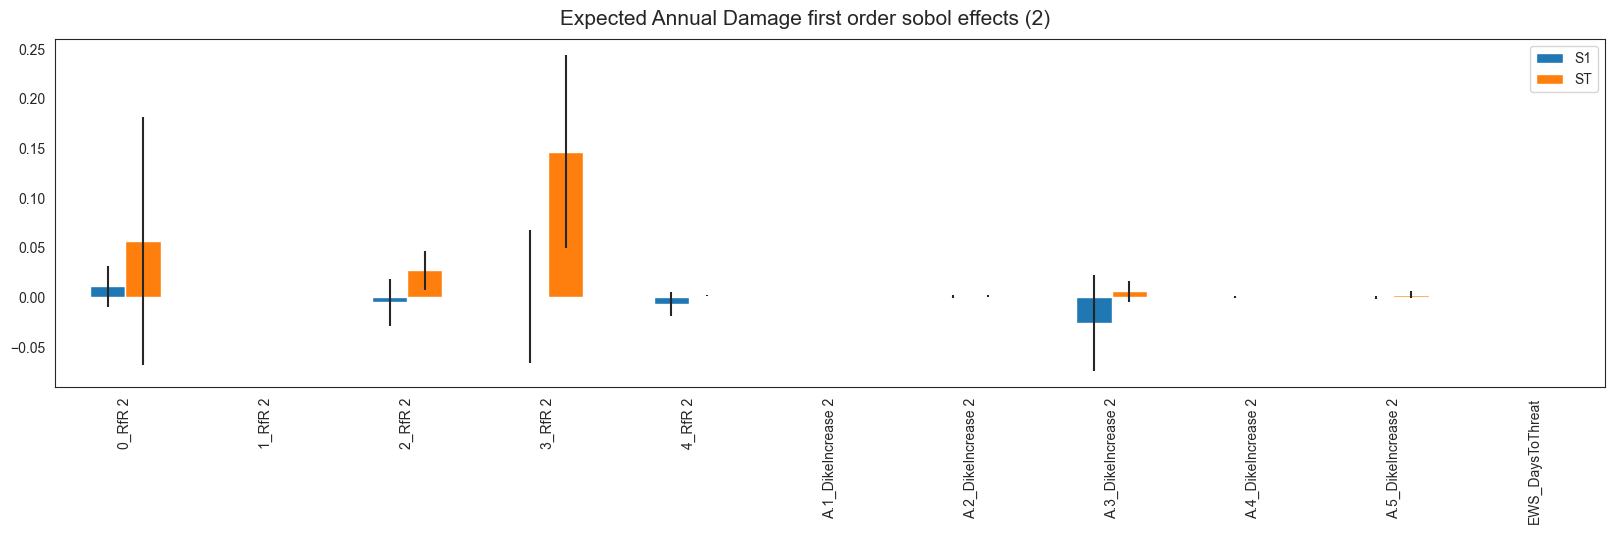

In [76]:
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'first','all')
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'first','0')
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'first','1')
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'first','2')

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


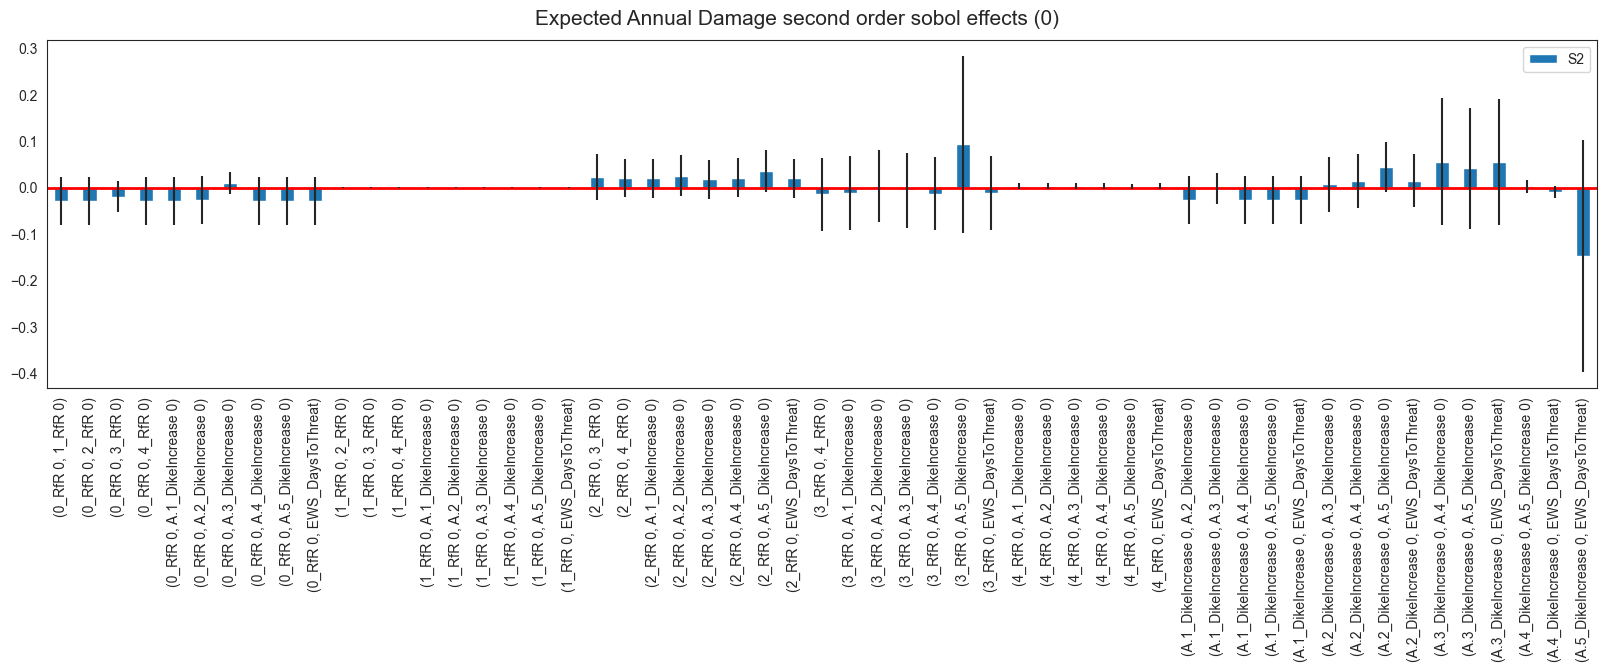

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


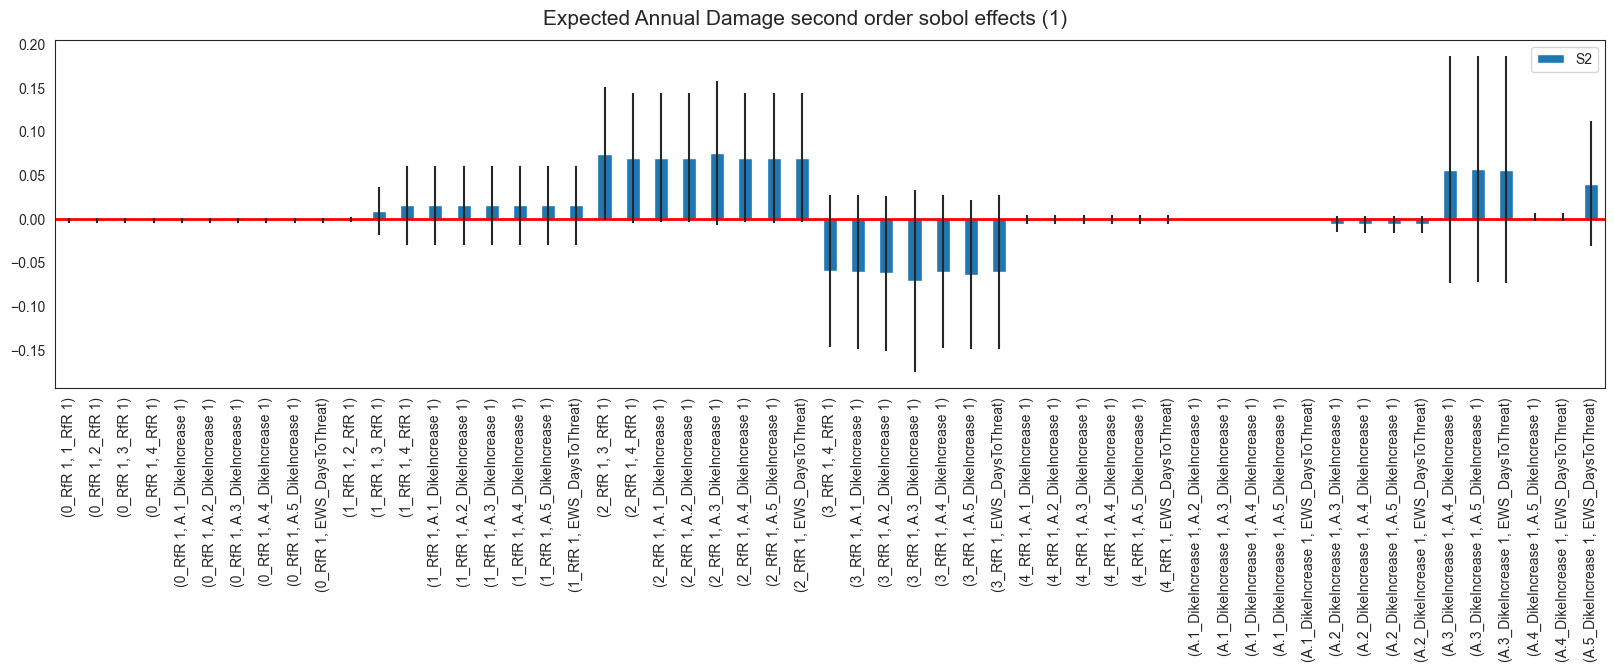

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


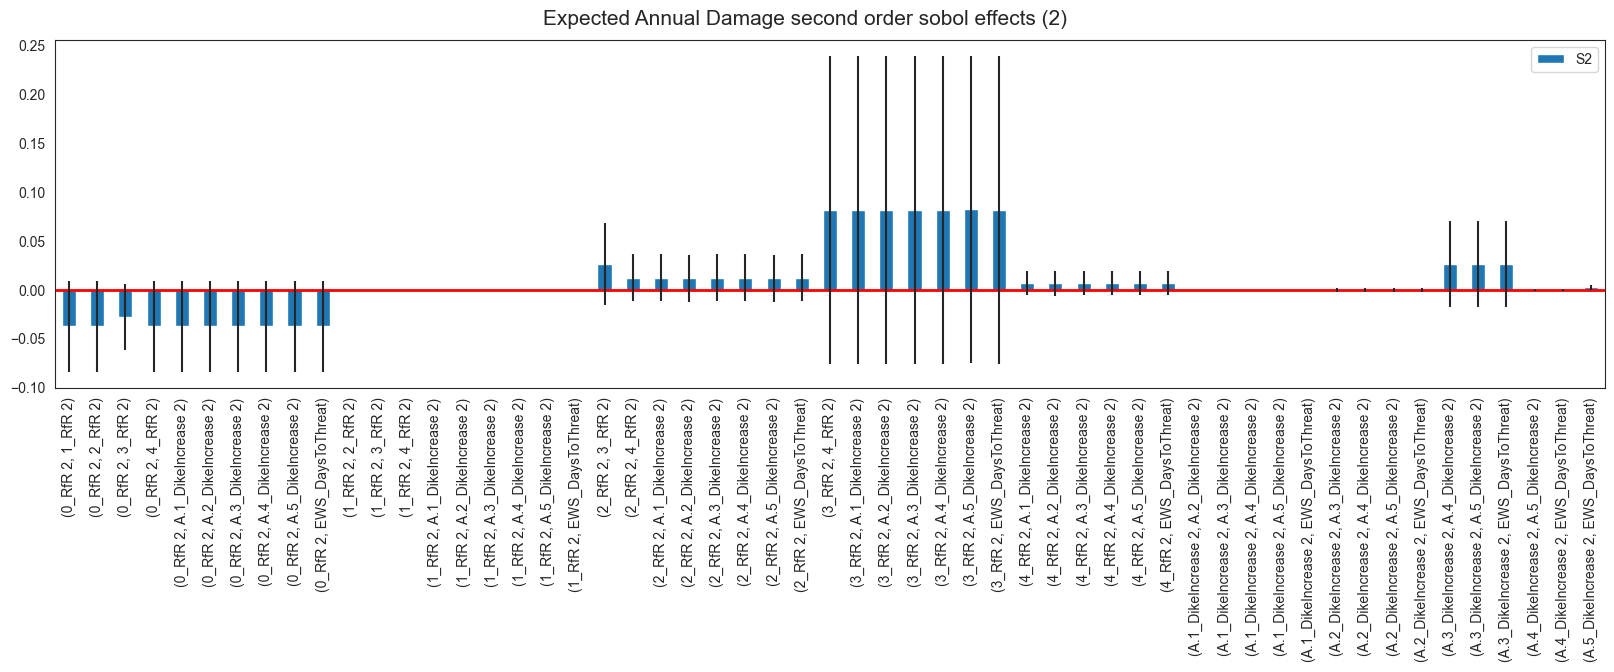

In [77]:
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'second','0')
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'second','1')
plot_sobol_effects(policy_space_dict,'Expected Annual Damage', 'second','2')

Feature scoring for policy space

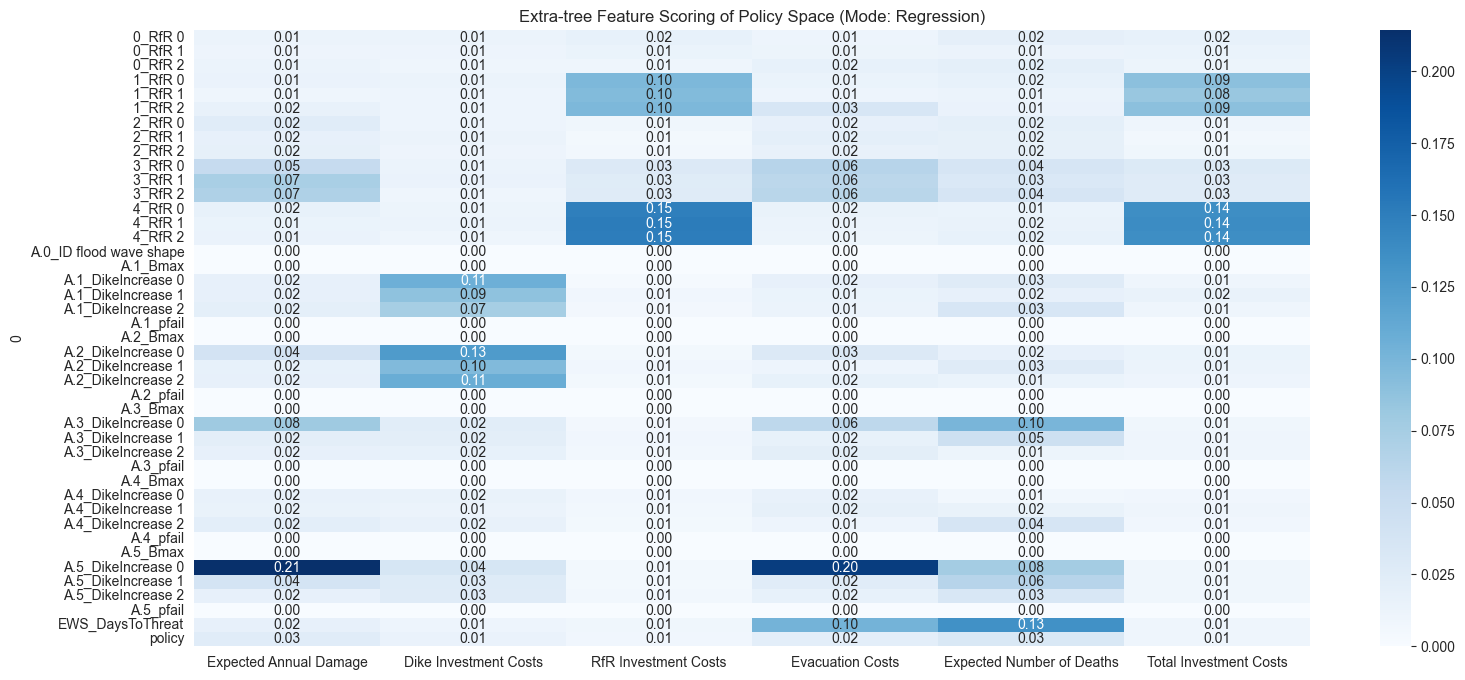

In [79]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(pol_experiments, pol_outcomes, mode=RuleInductionType.REGRESSION)
plt.figure(figsize=(18, 8))
ax = sns.heatmap(scores, annot=True, cmap = "Blues", fmt=".2f")
ax.set_title("Extra-tree Feature Scoring of Policy Space (Mode: Regression)")
plt.show()

### Analysis of the Uncertainty Space

In [82]:
# Load the results from the tar.gz file
results_unc = load_results('./results/uncertainty_space_refsc_1024sc.tar.gz')
unc_experiments, unc_outcomes = results_unc

# Convert the damage_sobol array to a DataFrame
unc_experiments_df = pd.DataFrame(unc_experiments)
    
# Convert outcomes_sobol dictionary to df
unc_outcomes_df = pd.DataFrame.from_dict(unc_outcomes)

# Merge DataFrames based on their index
unc_space = pd.merge(unc_experiments_df, unc_outcomes_df, left_index=True, right_index=True)

# Save the merged DataFrame to a CSV file
# policy_space.to_csv('policy_space.csv', index=True)
unc_space

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\uncertainty_space_refsc_1024sc.tar.gz


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
0,65,221.435068,1.5,0.568016,230.495099,1.5,0.300965,306.598073,1.0,0.587929,...,0,16384,Policy 0,dikesnet,5.212675e+08,0,0.0,0.0,0.617962,0.0
1,116,221.435068,1.5,0.568016,230.495099,1.5,0.300965,306.598073,1.0,0.587929,...,0,16385,Policy 0,dikesnet,4.994741e+08,0,0.0,0.0,0.611589,0.0
2,65,169.624319,1.5,0.568016,230.495099,1.5,0.300965,306.598073,1.0,0.587929,...,0,16386,Policy 0,dikesnet,5.212675e+08,0,0.0,0.0,0.617962,0.0
3,65,221.435068,1.5,0.568016,230.495099,1.5,0.300965,306.598073,1.0,0.587929,...,0,16387,Policy 0,dikesnet,5.212675e+08,0,0.0,0.0,0.617962,0.0
4,65,221.435068,1.5,0.166546,230.495099,1.5,0.300965,306.598073,1.0,0.587929,...,0,16388,Policy 0,dikesnet,1.505901e+09,0,0.0,0.0,1.382957,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,93,334.254074,1.5,0.778868,80.164839,1.5,0.875626,82.886031,10.0,0.878717,...,0,57339,Policy 0,dikesnet,2.453786e+08,0,0.0,0.0,0.283109,0.0
40956,93,334.254074,1.5,0.778868,80.164839,1.5,0.875626,82.886031,10.0,0.878717,...,0,57340,Policy 0,dikesnet,9.912701e+07,0,0.0,0.0,0.141942,0.0
40957,93,334.254074,1.5,0.778868,80.164839,1.5,0.875626,82.886031,10.0,0.878717,...,0,57341,Policy 0,dikesnet,8.840902e+07,0,0.0,0.0,0.141942,0.0
40958,93,334.254074,1.5,0.778868,80.164839,1.5,0.875626,82.886031,10.0,0.878717,...,0,57342,Policy 0,dikesnet,1.116441e+08,0,0.0,0.0,0.141942,0.0


Visualise the Sobol effects 

In [83]:
# Translate the uncertainty space dataframe back into a dictionary in order for the sobol calculations to work
uncertainty_space_dict = {col: unc_space[col].to_numpy() for col in unc_space.columns}
# uncertainty_space_dict

In [88]:
results = load_results('./results/uncertainty_space_refsc_1024sc.tar.gz')
unc_experiments, unc_outcomes = results


model, steps = get_model_for_problem_formulation(6)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\uncertainty_space_refsc_1024sc.tar.gz


In [89]:
# Function used to flatten Sobol S2 dictionary output

def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        array = []
        for row in value:
            array.extend(row)
        flattened_dict[key] = array

    return flattened_dict

In [90]:
def plot_sobol_effects(run_dict, variable, order, timestep):
    # Prepare Sobol variables
    problem = get_SALib_problem(uncertainties)
    outcome_var = variable
    Si = sobol.analyze(problem, run_dict[outcome_var], print_to_console=False)
    
    
    if order == 'first':
        # Process dataframe: filter S1+ST
        Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
        
        if timestep == 'all':
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df[['S1','ST']]
            err = Si_df[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
                
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            
            # Filter Si_df based on filtered_names
            Si_df_filtered = Si_df.loc[filtered_names]
            
            # Visualize Sobol indices for filtered names
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df_filtered[['S1','ST']]
            err = Si_df_filtered[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
    if order =='second':
        
        if timestep == 'all':
            Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

            # Filter out rows where S2 is greater than 0.1
            S2_df_filtered = S2_df_sorted[S2_df_sorted['S2'] <= 0.1]

            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = S2_df_filtered[["S2"]]
            err = S2_df_filtered[['S2_conf']]
            
            fig.set_size_inches(20,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
            
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            combinations = list(itertools.product(filtered_names, repeat=2))
            
            # Assuming Si_filter_s2 and S2_df are generated as in your code snippet
            Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))
            
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)
            S2_df_filtered = S2_df_sorted.loc[combinations]
            
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            # Drop NaN values from 'S2' and 'S2_conf' columns
            indices = S2_df_filtered[["S2"]].dropna()
            err = S2_df_filtered[['S2_conf']].dropna()
            
            fig.set_size_inches(30,10)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
    
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.suptitle(f'{variable} {order} order sobol effects ({timestep})', fontsize=15, y=0.93)
    fig.subplots_adjust(bottom=0.3)
    
    plt.show()
    return

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


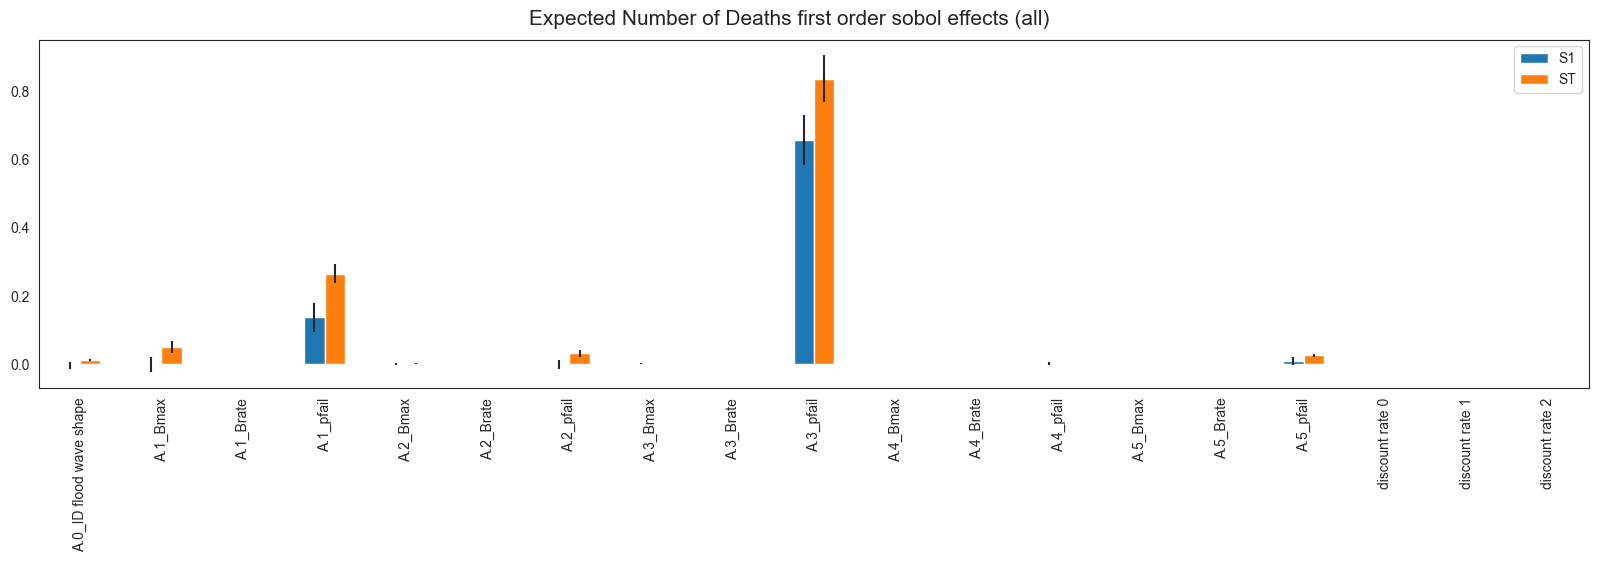

In [91]:
plot_sobol_effects(uncertainty_space_dict,'Expected Number of Deaths', 'first','all')

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


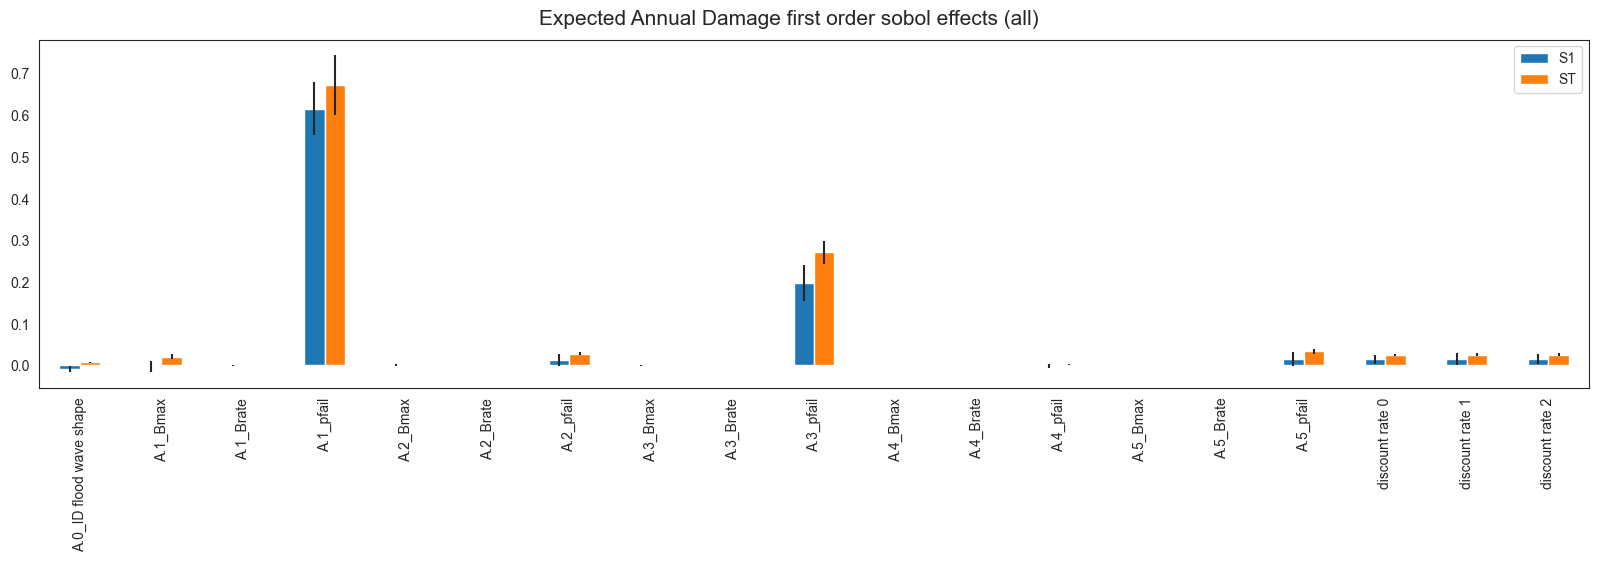

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


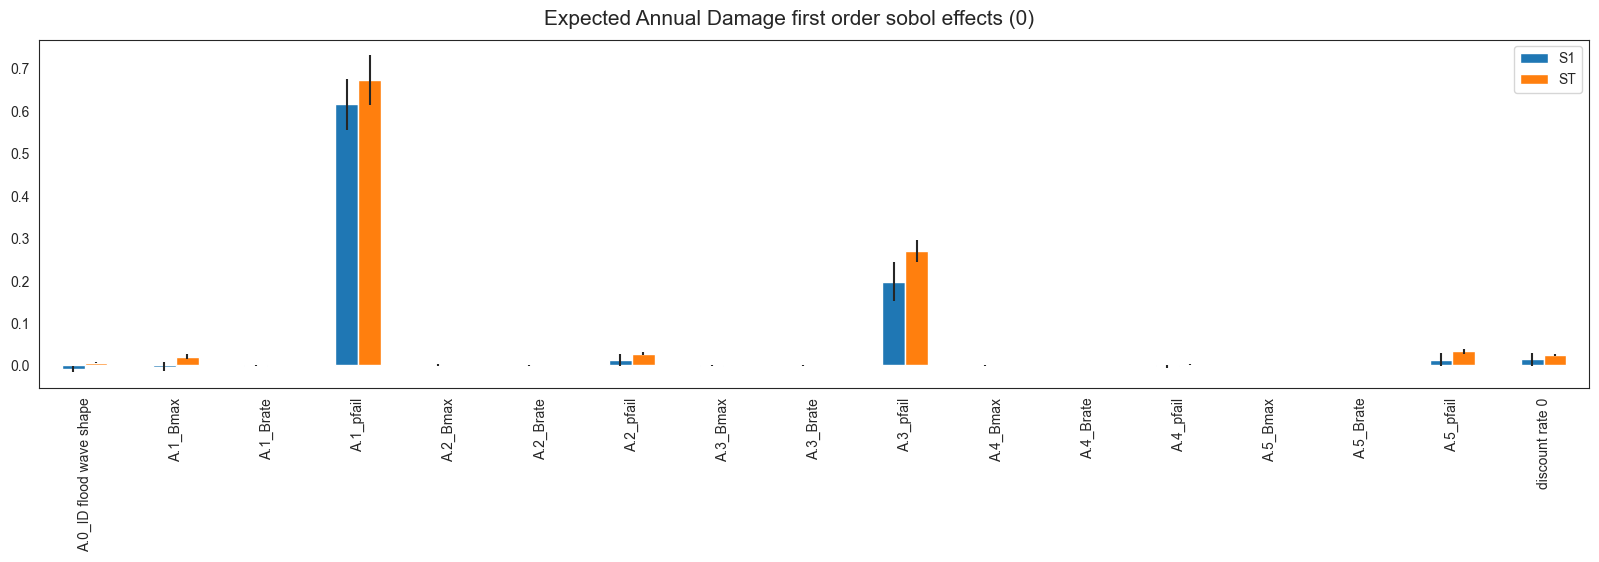

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


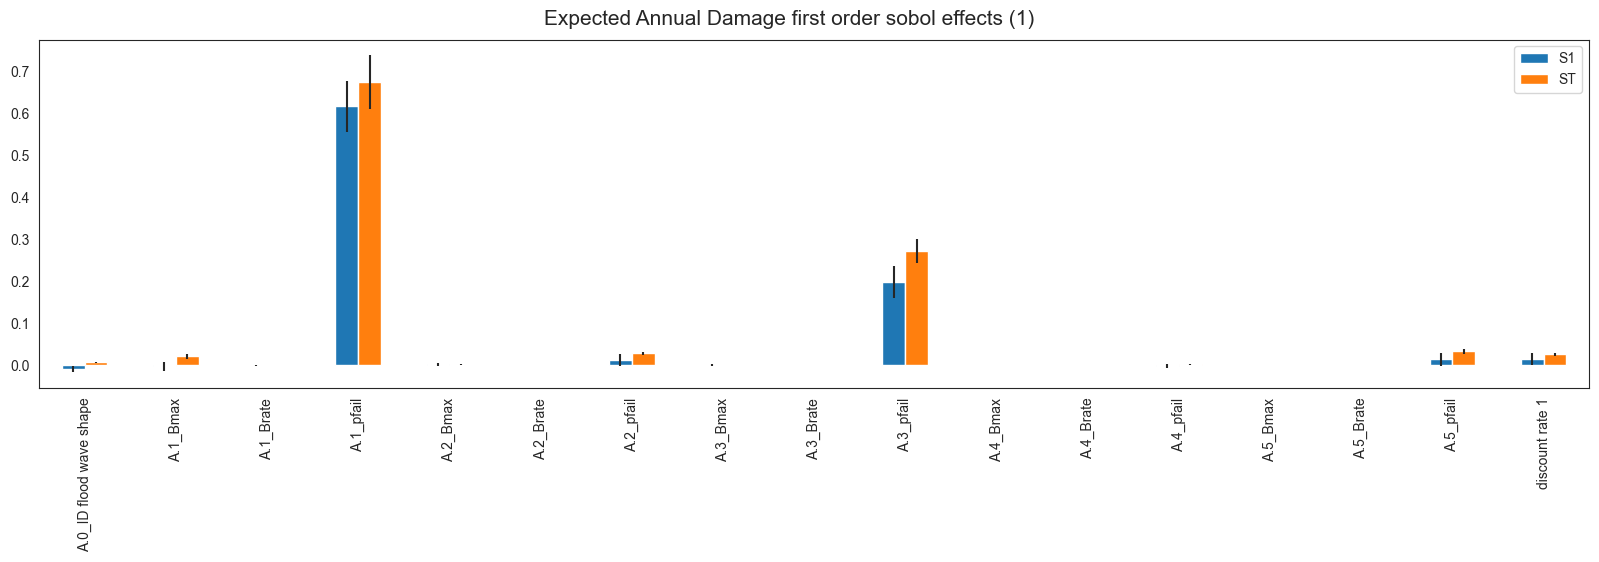

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


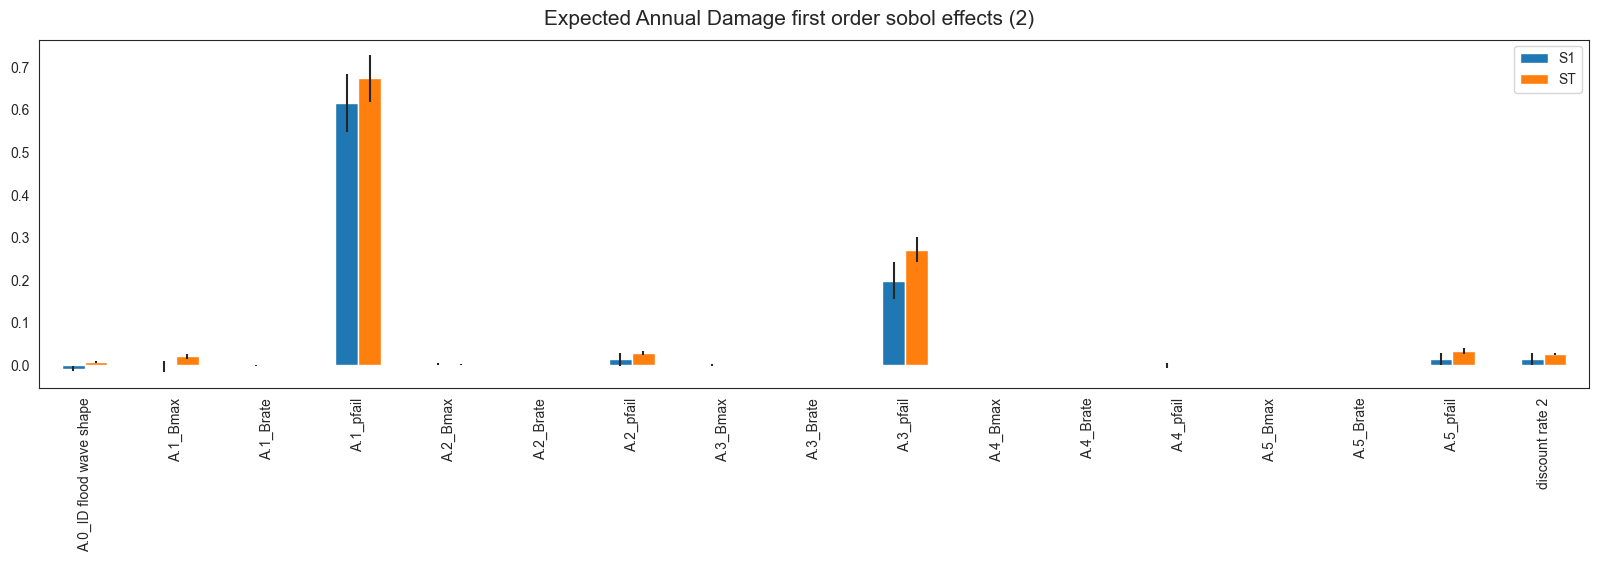

In [92]:
plot_sobol_effects(uncertainty_space_dict,'Expected Annual Damage', 'first','all')
plot_sobol_effects(uncertainty_space_dict,'Expected Annual Damage', 'first','0')
plot_sobol_effects(uncertainty_space_dict,'Expected Annual Damage', 'first','1')
plot_sobol_effects(uncertainty_space_dict,'Expected Annual Damage', 'first','2')

In [93]:
def sort_second_order_overall_effects(variable):
    problem = get_SALib_problem(uncertainties)
    Si = sobol.analyze(problem, uncertainty_space_dict[variable], print_to_console=False)
    
    Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
    Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
    S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))

    # Sort S2_df by 'S2' in descending order
    S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

    # Filter rows where 'S2' > 0
    S2_df_sorted_filtered = S2_df_sorted[abs(S2_df_sorted['S2']) > 0.01]

    # Visualize Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    # Drop NaN values from 'S2' and 'S2_conf' columns
    indices = S2_df_sorted_filtered[["S2"]].dropna()
    err = S2_df_sorted_filtered[['S2_conf']].dropna()

    # Plotting bar chart
    indices.plot.bar(yerr=err.values.T, ax=ax)
    
    # Set x-axis label fontsize
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

    # Adding title and adjusting figure
    fig.suptitle(f'{variable} sorted', fontsize=15, y=0.93)
    fig.set_size_inches(40, 20)  # Adjust figure size as needed
    fig.subplots_adjust(bottom=0.3)

    plt.show()
    return

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


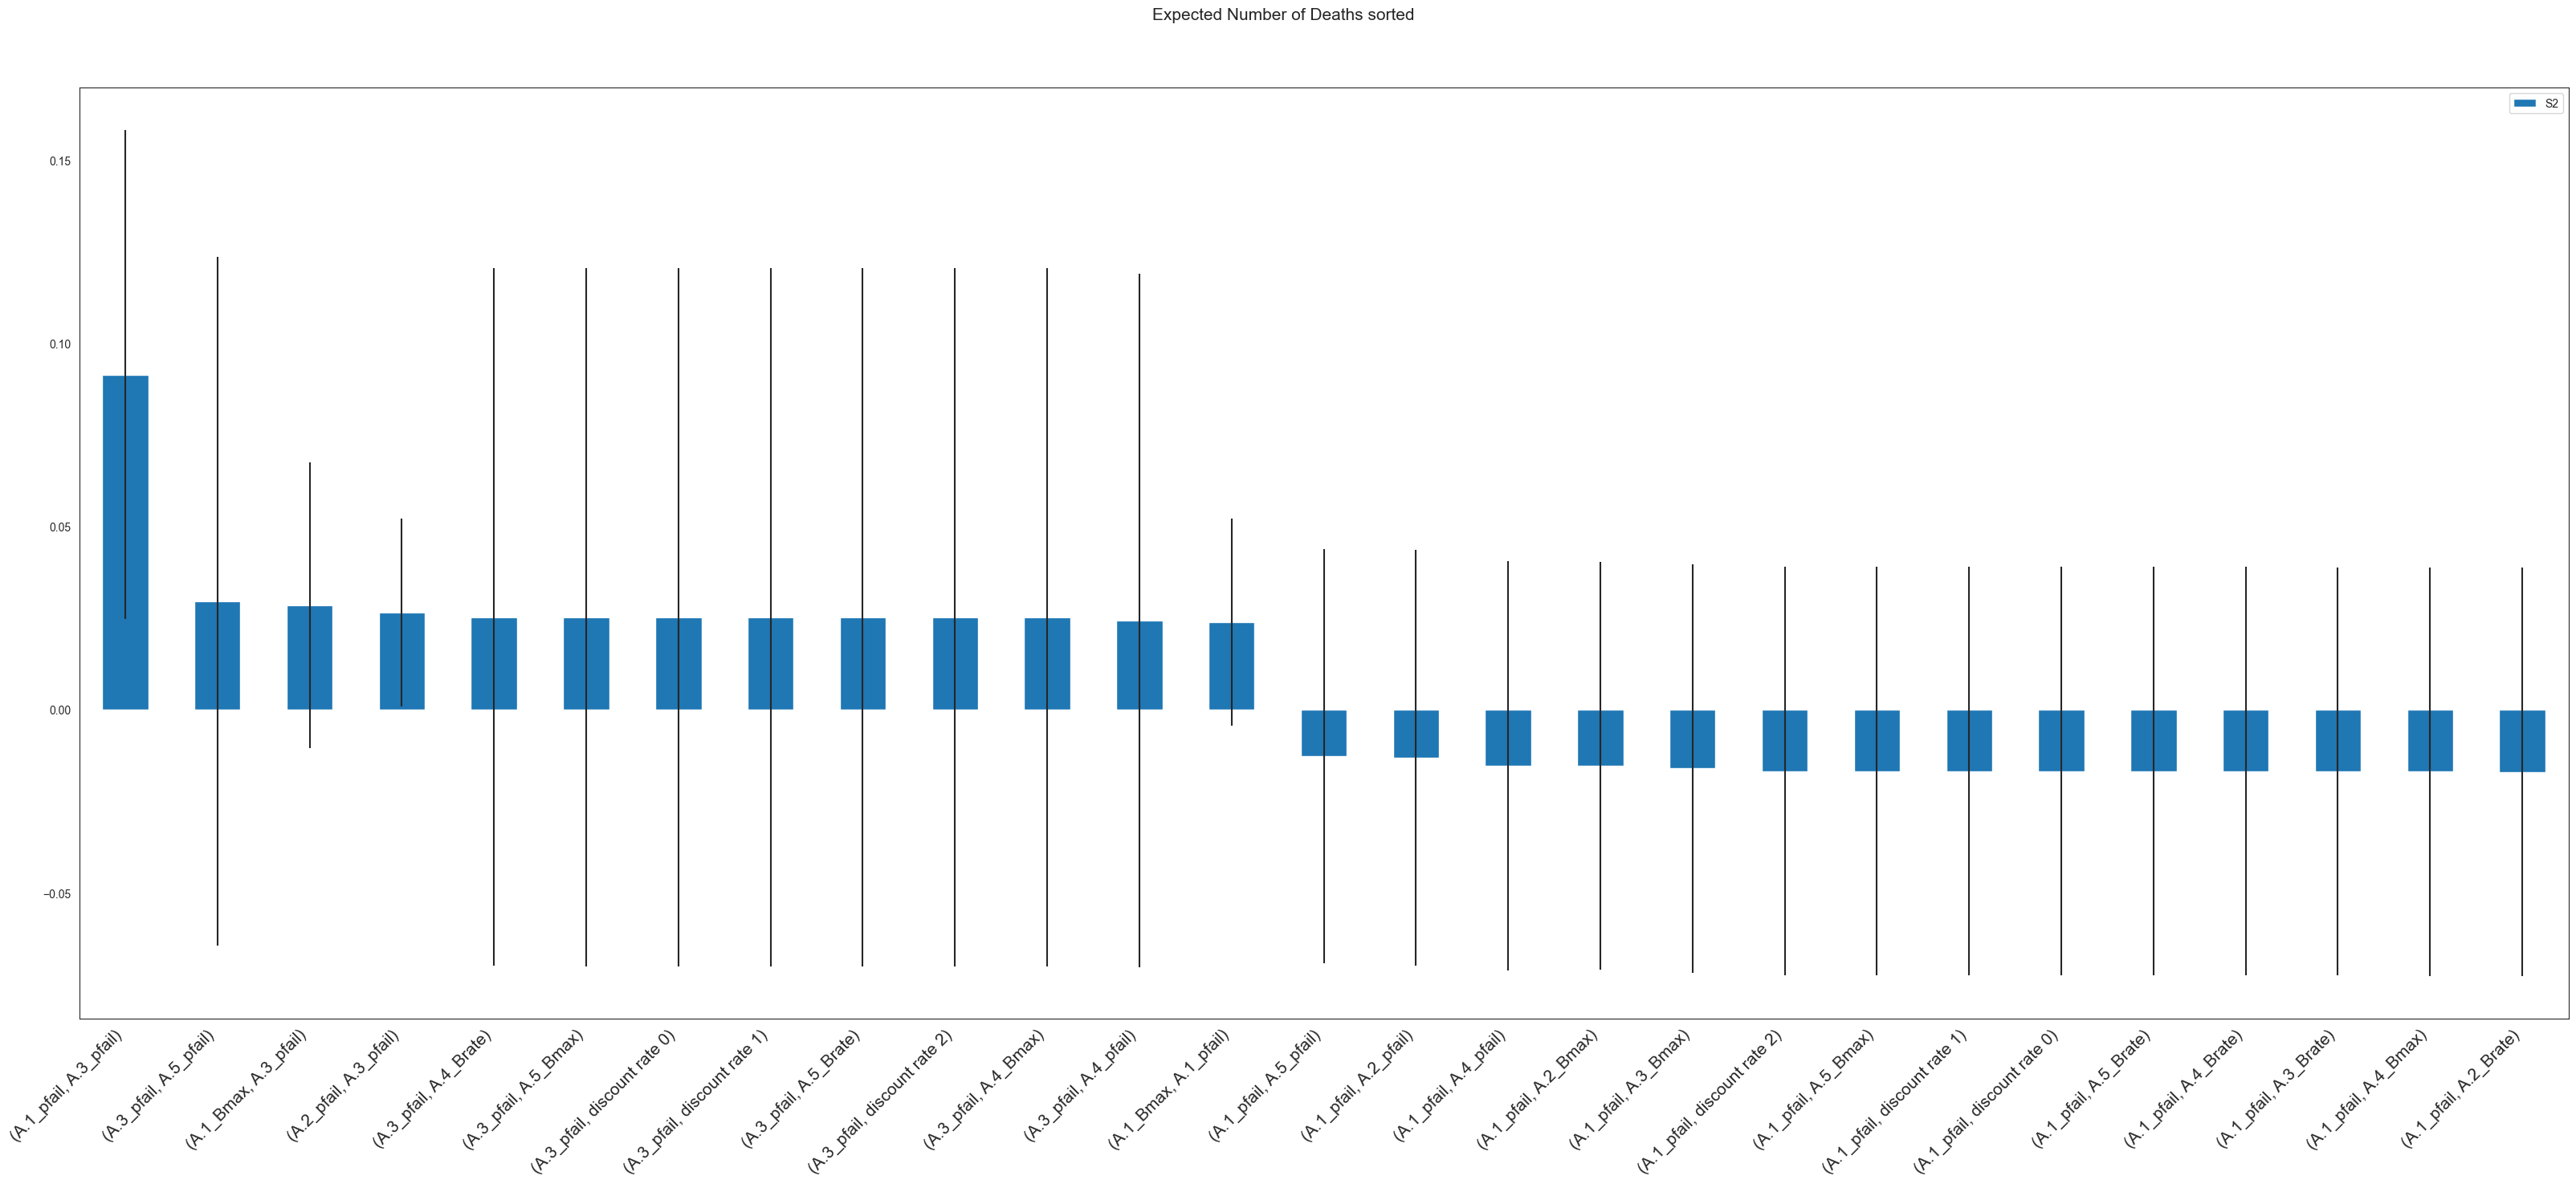

c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


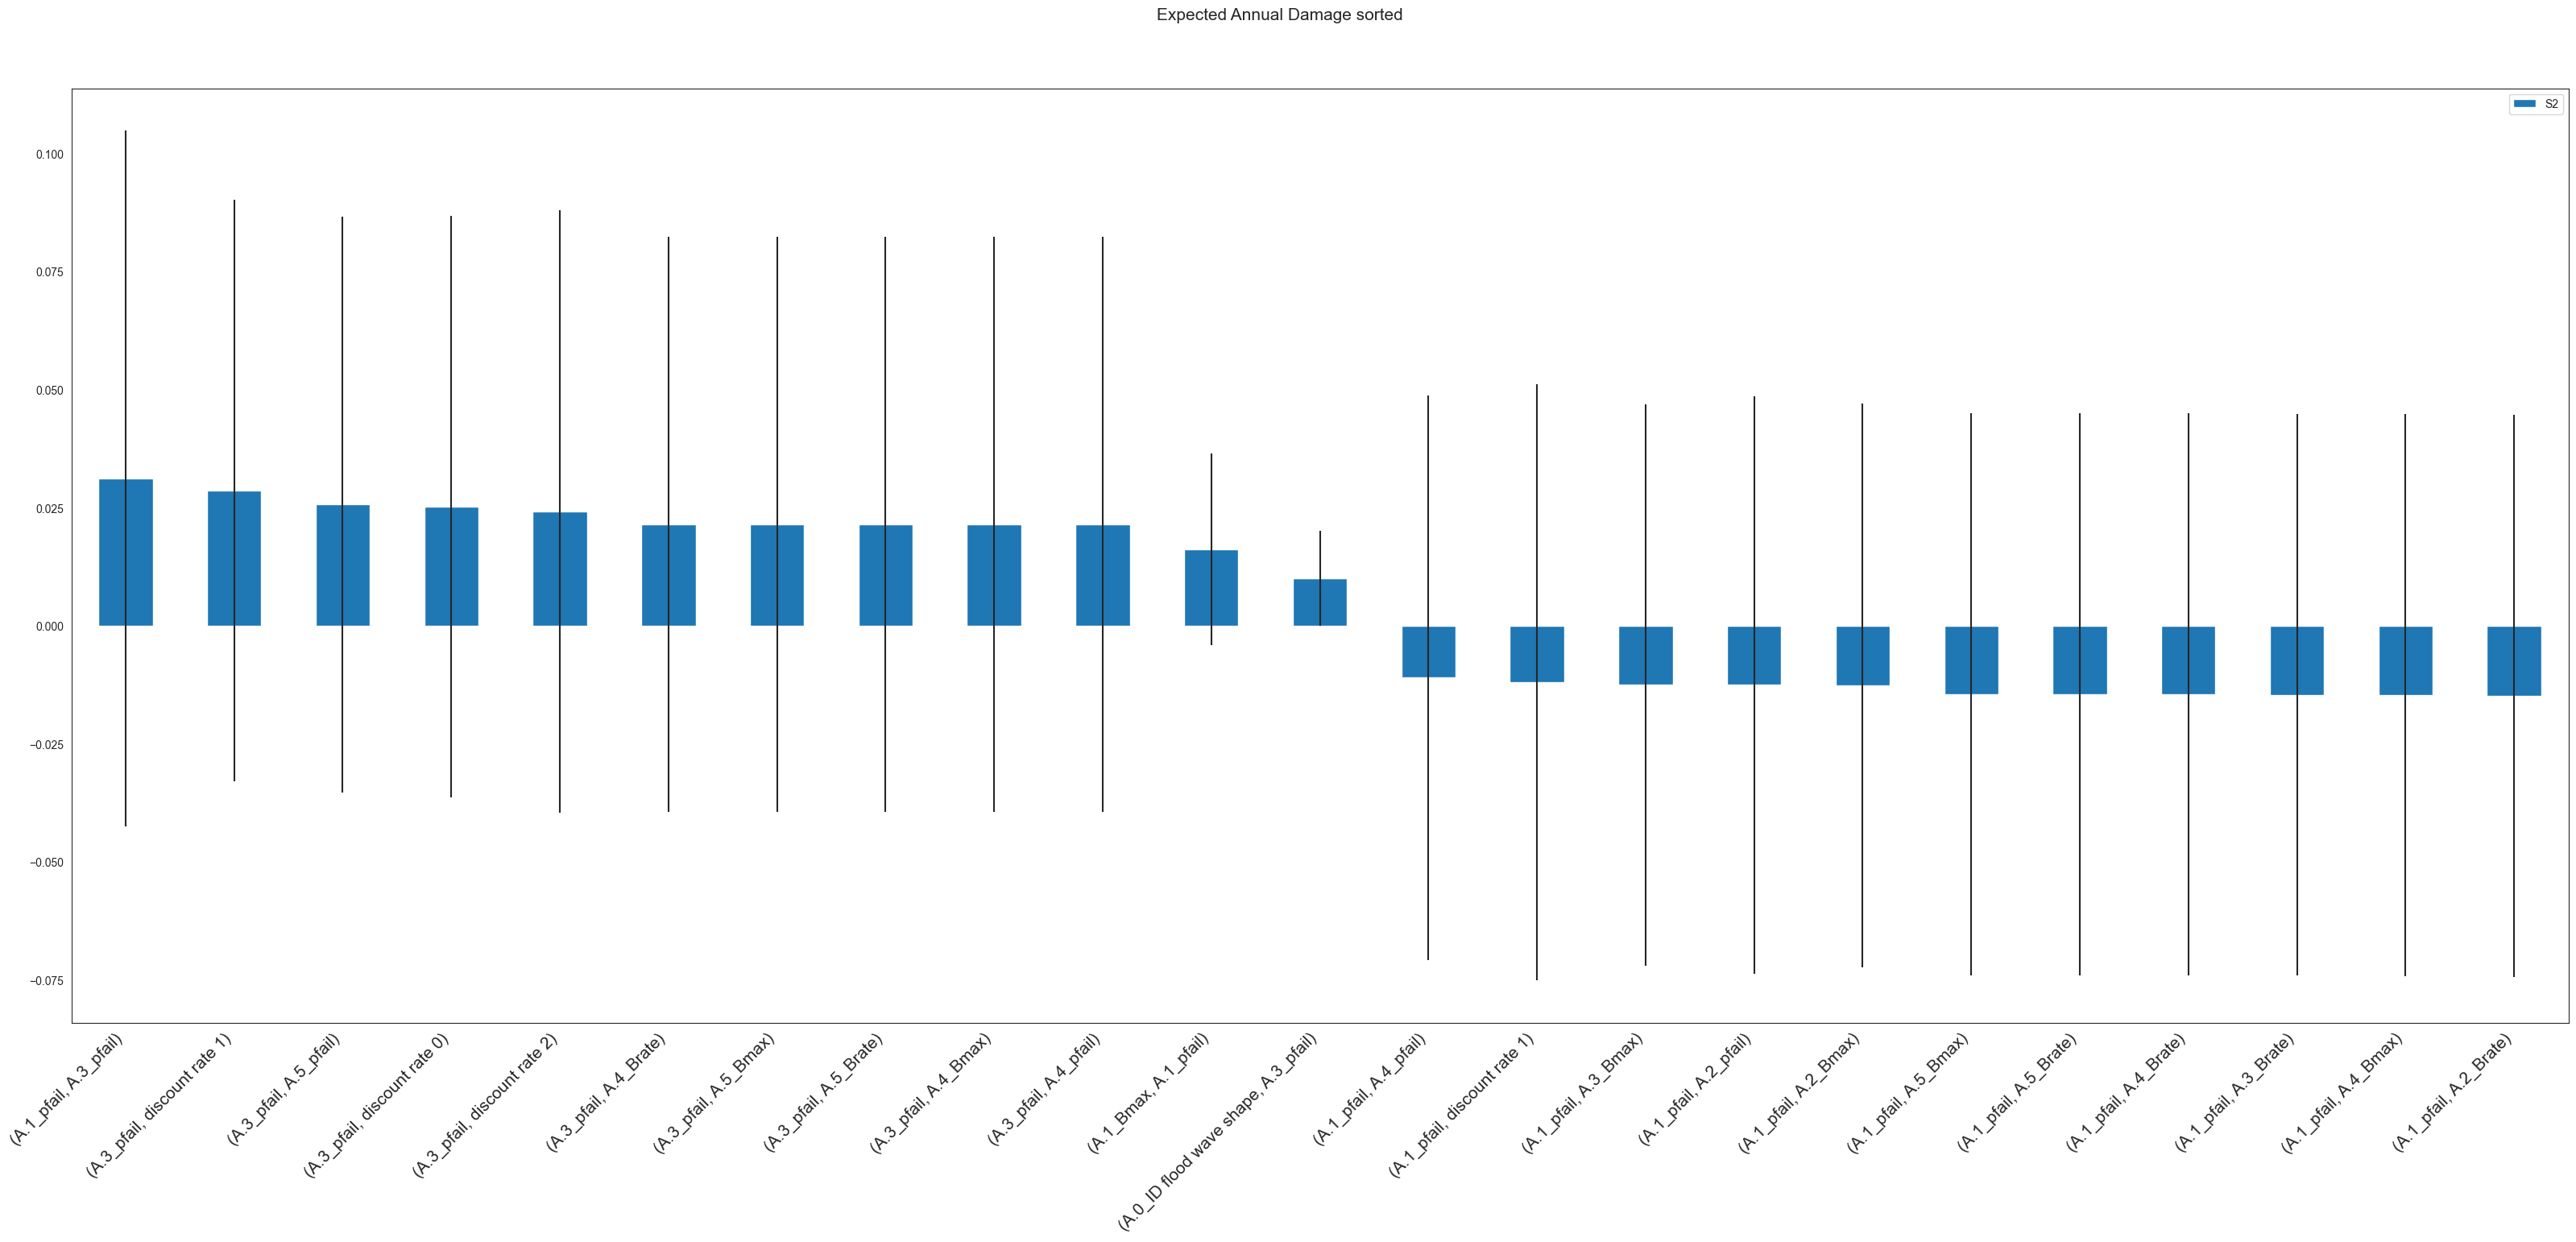

In [94]:
sort_second_order_overall_effects('Expected Number of Deaths')
sort_second_order_overall_effects('Expected Annual Damage')

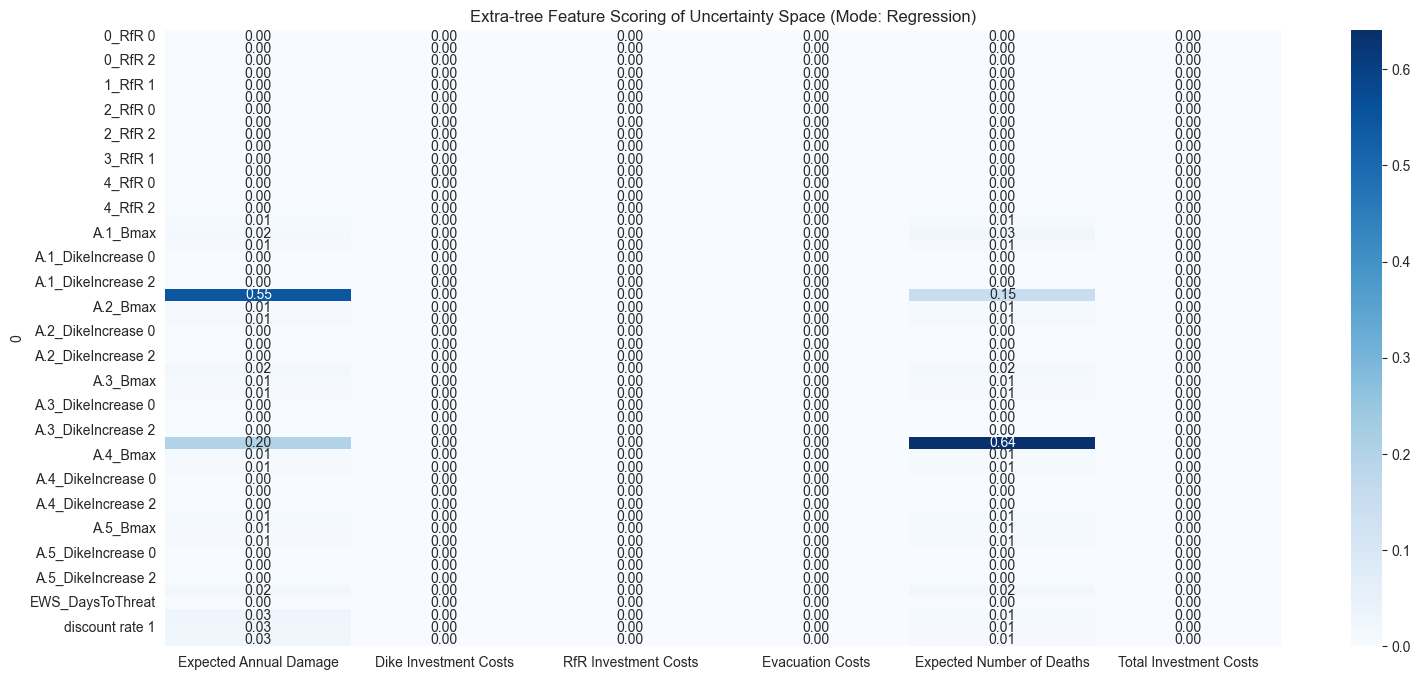

In [ ]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(unc_experiments, unc_outcomes, mode=RuleInductionType.REGRESSION)
plt.figure(figsize=(18, 8))
ax = sns.heatmap(scores, annot=True, cmap = "Blues", fmt=".2f")
ax.set_title("Extra-tree Feature Scoring of Uncertainty Space (Mode: Regression)")
plt.show()